In [252]:
import numpy as np
import pandas as pd

from time import time
from datetime import timedelta

import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))

# Data collection

In [2]:
def read_tide(filepath, datetime_pattern=slice(0,13)):
    df = pd.read_csv(filepath)
    df['Date Time'] = [date[datetime_pattern] for date in df['Date Time']]
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.groupby(['Date Time']).mean()
    return df.reset_index()

In [3]:
orig_train = read_tide('BHPtraining.csv')
orig_test = read_tide('BHPtest.csv')

# Data cleaning

## Convert it to hourly

In [4]:
orig_train

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.90,2.4475,0.1492,4.860,136.111111,5.355556
1,2017-01-01 01:00:00,63.98,2.2461,0.1629,4.237,134.200000,4.666000
2,2017-01-01 02:00:00,64.18,2.2506,0.1539,5.073,129.700000,5.404000
3,2017-01-01 03:00:00,64.30,2.1027,0.1608,5.015,112.200000,5.287000
4,2017-01-01 04:00:00,64.18,2.0279,0.1686,6.725,82.800000,7.115000
...,...,...,...,...,...,...,...
26275,2019-12-31 19:00:00,59.56,0.5822,0.2331,14.929,27.500000,17.630000
26276,2019-12-31 20:00:00,59.27,0.7208,0.2327,14.346,27.900000,17.027000
26277,2019-12-31 21:00:00,59.08,0.9824,0.2450,13.550,28.200000,16.327000
26278,2019-12-31 22:00:00,58.72,1.2382,0.2184,14.112,26.100000,16.619000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001763884EE88>,
      dtype=object)

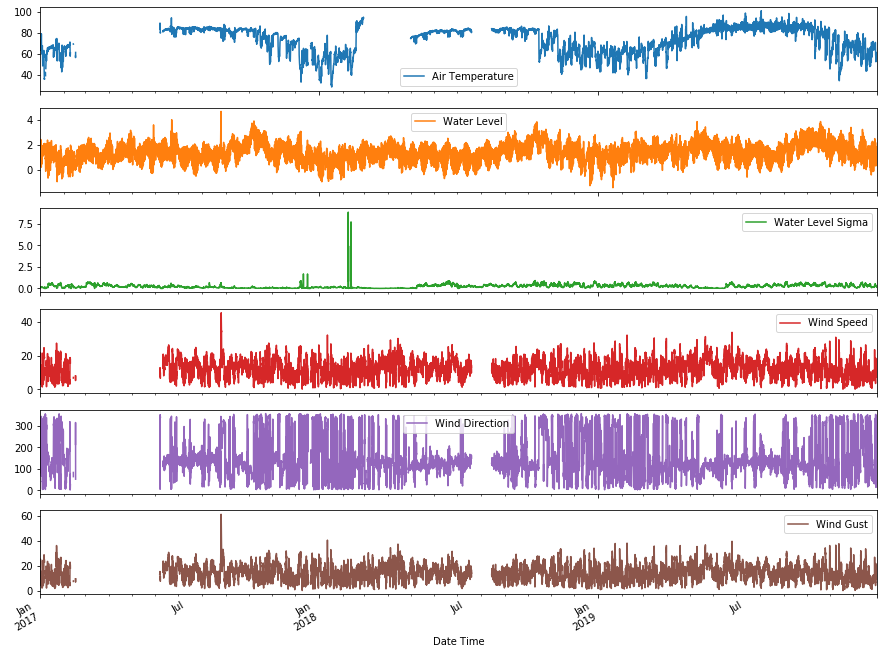

In [5]:
orig_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

## Merging data and test

Merging back train and test data for easy differencing

In [195]:
merged = pd.concat([orig_train, orig_test])
merged

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.900000,2.447500,0.149200,4.860000,136.111111,5.355556
1,2017-01-01 01:00:00,63.980000,2.246100,0.162900,4.237000,134.200000,4.666000
2,2017-01-01 02:00:00,64.180000,2.250600,0.153900,5.073000,129.700000,5.404000
3,2017-01-01 03:00:00,64.300000,2.102700,0.160800,5.015000,112.200000,5.287000
4,2017-01-01 04:00:00,64.180000,2.027900,0.168600,6.725000,82.800000,7.115000
...,...,...,...,...,...,...,...
7053,2020-10-20 21:00:00,80.440000,1.858000,0.385200,12.091000,74.600000,13.783000
7054,2020-10-20 22:00:00,79.770000,2.366700,0.380500,12.206000,78.600000,13.898000
7055,2020-10-20 23:00:00,79.430000,2.721800,0.384300,12.497000,74.900000,14.228000
7056,2020-10-21 00:00:00,79.320000,2.967100,0.399600,13.431000,78.600000,15.298000


## Fill missing values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017687EE96C8>,
      dtype=object)

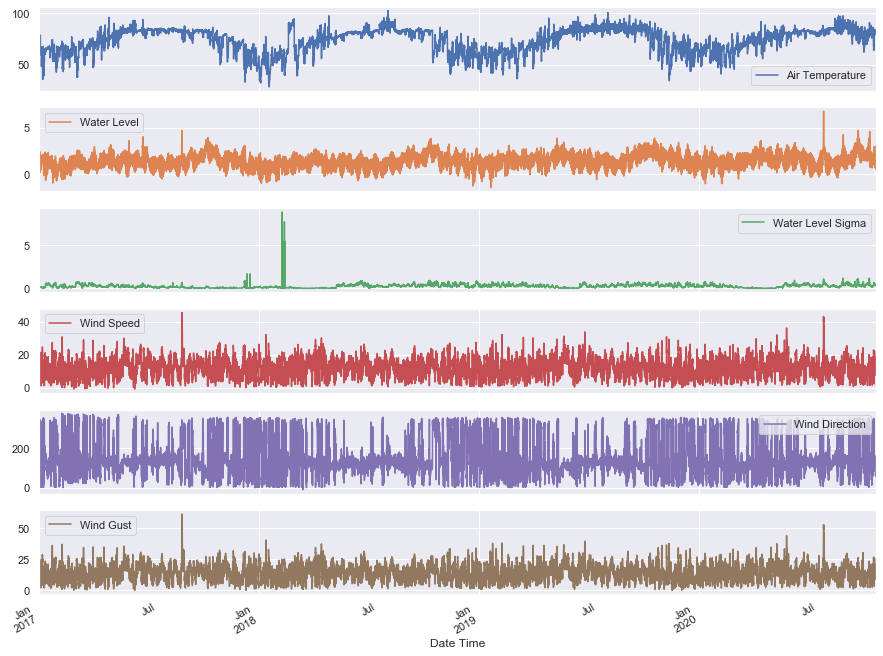

In [248]:
preprocessed = merged.copy().set_index('Date Time')
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp,period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = '2019-' + str(results.resid.index[i])[5:]
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.reset_index(inplace=True)    

preprocessed.plot(x = 'Date Time', figsize=(15, 12), subplots=True)

## Stationary  test

In [9]:
def stationary_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [216]:
water_level_df = preprocessed[['Date Time', 'Water Level']].copy().set_index('Date Time')
water_level_df.dropna(inplace=True)
stationary_test(water_level_df['Water Level'].values)

ADF Statistic: -8.366553
p-value: 0.000000


The p-value is significant enough, so it might be tempted to conclude that the data is already stationary.  

However, we know that the data should be seasonal, as in below

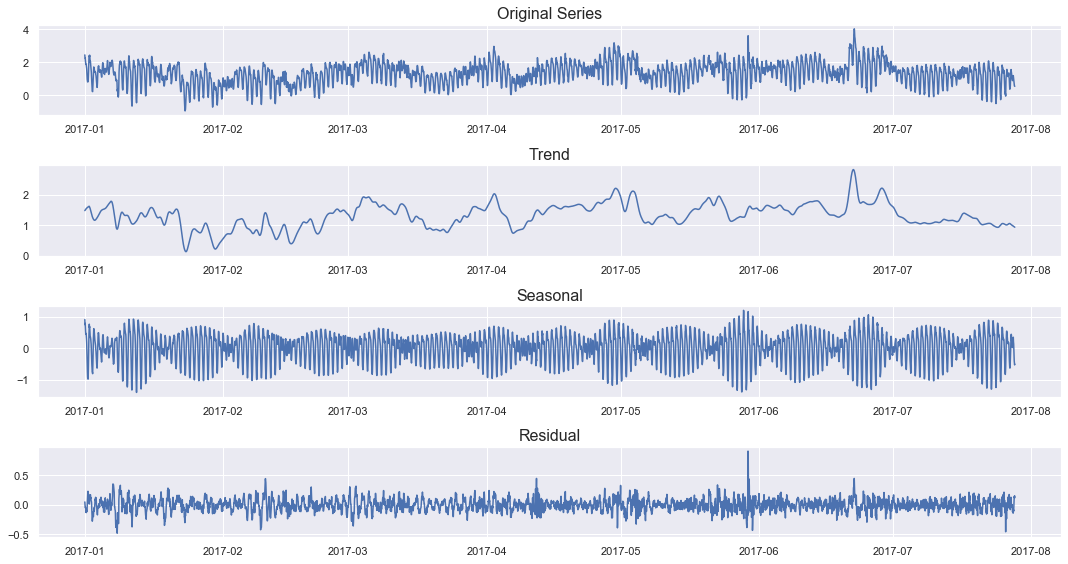

In [217]:
first_5k_obs = water_level_df['Water Level'][:5000]

stl = STL(first_5k_obs)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(first_5k_obs)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Performing differencing

ADF Statistic: -20.239350
p-value: 0.000000


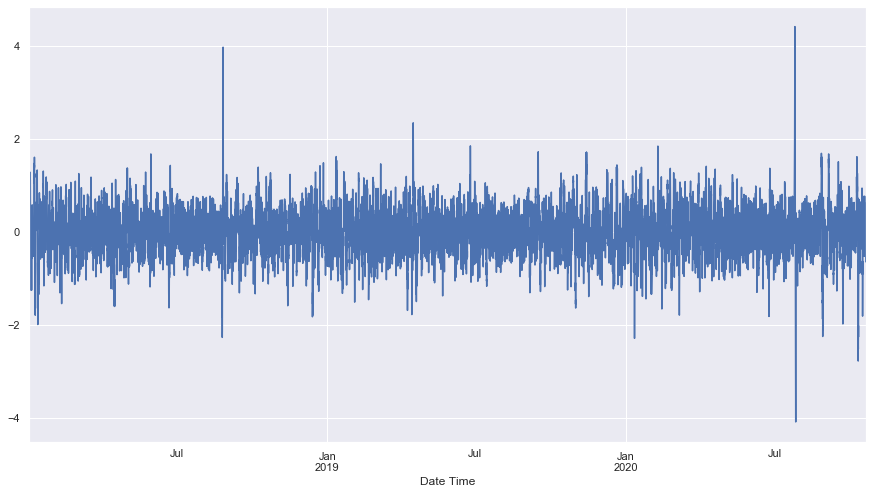

In [218]:
diff_merged = preprocessed.copy()

diff_merged = diff_merged.bfill().ffill().interpolate()
diff_merged.set_index('Date Time', inplace=True)

diff_merged = diff_merged.diff(periods=24)[1:]              # by 1 day
diff_merged = diff_merged.diff(periods=365*24).dropna()     # by 1 year

wl_df = diff_merged['Water Level']
stationary_test(wl_df)
wl_df.plot(x='Date Time', figsize=(15,8))

# diff_merged.plot(figsize=(15, 12), subplots=True)

### Splitting back into train and test set

In [222]:
boundary = pd.to_datetime('2020/01/01')
train = diff_merged[:boundary-timedelta(days=1)]
test = diff_merged[boundary:]

In [223]:
wl_train = pd.DataFrame(train['Water Level'])
wl_test = pd.DataFrame(test['Water Level'])

## ACF and PACF

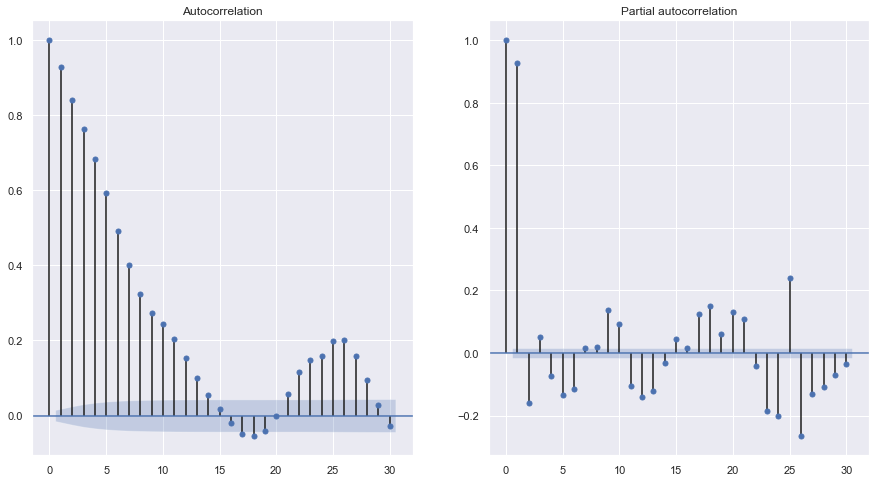

In [224]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
lags = 30
sm.graphics.tsa.plot_acf(wl_train, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(wl_train, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

For ACF, we can see that 25 is the most significant lag, so let's try with seasonality of around 24-25.

# SARIMA model

In [225]:
def train_model(df, periodicity=24, track_time=False):
    model = SARIMAX(df, order=(0,1,0), seasonal_order=(1,0,1,periodicity))

    #fit the model
    start = time()
    model_fit = model.fit()
    end = time()
    if track_time:
        print('Model Fitting Time:', end - start)
    
    return model_fit

### Brute-force

Let's calculate the AIC of some reasonable periods

In [17]:
periods = [6,12,18,24,25]
for period in periods:
    model = train_model(wl_train['Water Level'].values, period)
    print('{} {}'.format(period, model.aic))

6 -10663.603623458795
12 -12182.544265754028
18 -10817.024915202173
24 -13553.8247153439
25 -12483.64153879625


Since a period 24 hours gives lowest value of AIC, we're gonna use that for now.

In [226]:
model = train_model(wl_train['Water Level'].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6779.911
Date:                              Mon, 02 Nov 2020   AIC                         -13553.823
Time:                                      16:35:47   BIC                         -13530.518
Sample:                                           0   HQIC                        -13546.148
                                            - 17473                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6714      0.005    123.535      0.000       0.661       0.682
ma.S.L24      -1.0000      0.265     -3.775      0.000      -1.519      -0.481
sigma2         0.0268      0.007      3.791      0.000       0.013       0.041
===================================================================================
Ljung-Box (L1) (Q):                 849.03   Jarque-Bera (JB):              1691.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [250]:
# get the predictions and residuals
predictions = model.forecast(len(wl_test)+1)
predictions = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test.index)
residuals = wl_test - predictions

# predictions

,Water Level
count,7058.000000
mean,0.000985
std,0.542170
min,-4.094483
25%,-0.308558
50%,0.003617
75%,0.330954
max,4.411317


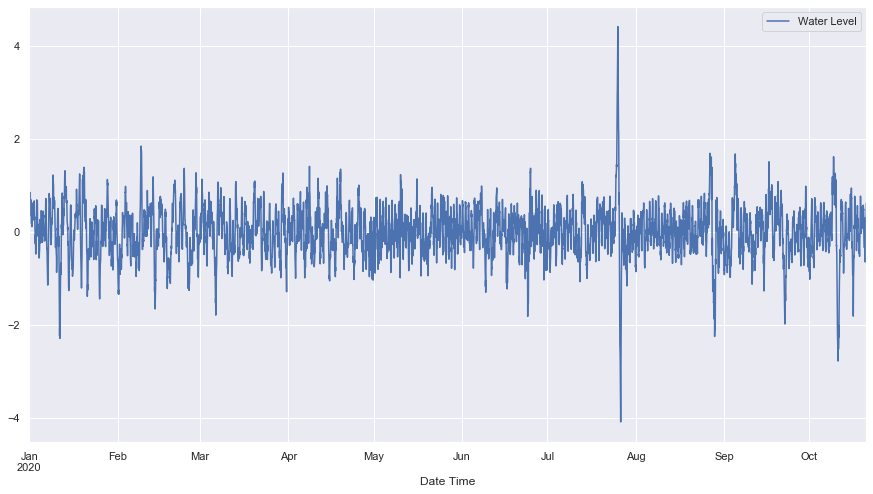

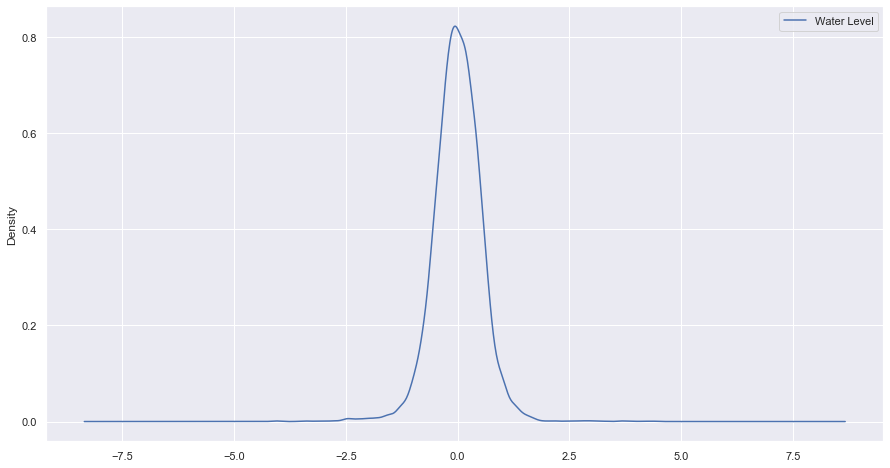

In [229]:
residuals.plot(figsize=(15,8))
residuals.plot(kind='kde', figsize=(15,8))
residuals.describe()

In [291]:
def plot_prediction(y_true, y_pred):
    plt.figure(figsize=(15,8))

    plt.plot(y_true)
    plt.plot(y_pred)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title('Water level data in 2020', fontsize=20)
    plt.ylabel('Water level', fontsize=16)
    
    last_month = y_pred.index[-1].month
    for month in range(1,last_month+1):
        plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)

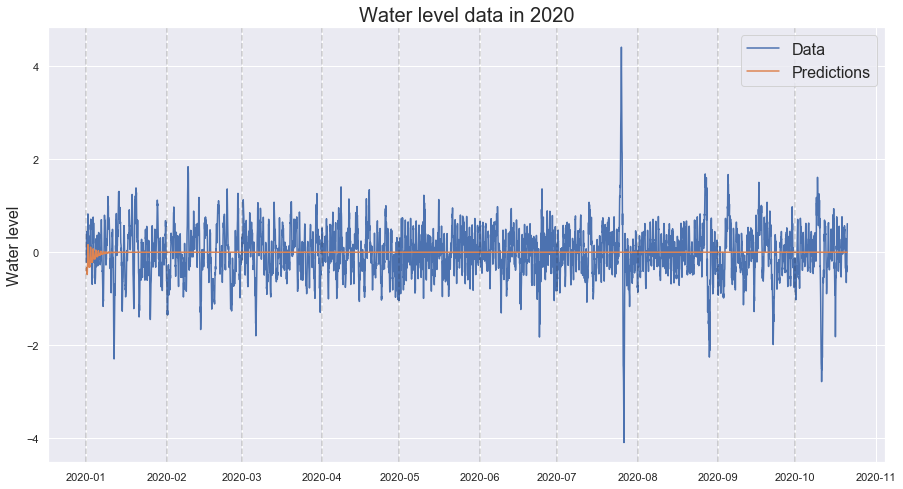

In [292]:
plot_prediction(wl_test, predictions)

We could clearly see that the prediction doesn't work quite well. I guess the model probably isn't suitable for predicting large amount of data.

In [322]:
def evaluate(pred, test, model=''):
    mse = mean_squared_error(test, pred)
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)
    medae = median_absolute_error(test, pred)
    
    me = (test.values - pred.values).mean()
    
    errors = {'Model': model, 'RMSE': sqrt(mse), 'R2': r2, 'MSE': mse, 'ME': me, 'MAE': mae, 'MedAE': medae}
    
    eval_df = pd.DataFrame(errors, index=[model]).round(3)
    return eval_df

In [323]:
evaluate(wl_test, predictions)

,Model,RMSE,R2,MSE,ME,MAE,MedAE
,,0.542,-516.758,0.294,-0.001,0.4,0.32


## Using the Rolling Forecast Origin

Since the above implementation didn't work, I decided to do a rolling forecast.  
Basically, it builds the  model, then predicts one day, then rebuilds the model, then predicts the next day, and so on.

In [51]:
from IPython.display import display, clear_output

history = [x for x in wl_train['Water Level'].values]
future = wl_test['Water Level'].copy()
rolling_pred = list()

# time tracking
start = time()

steps = 24    # a day
total_steps = int(len(wl_test) / steps)

for t in range(total_steps):
    print("Date: {}/{}".format(t, total_steps))
    print_elapsed_time(start)
    
    # train
    model = train_model(history)
    
    # predict
    output = model.forecast(steps)
    yhat = output
    rolling_pred.extend(yhat)
    
    # add current day to training data
    obs = future[t*steps:(t+1)*steps].values
    history.extend(obs)
    
    clear_output(wait=True)
    # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

clear_output(wait=True)
print_elapsed_time(start)

Total time: 6876.48 sec


In [52]:
rolling_pred_df = pd.DataFrame(rolling_pred, columns=['Water Level'], index=wl_test[:len(rolling_pred)].index)
rolling_pred_df

,Water Level
Date Time,
2020-01-01 00:00:00,-0.443648
2020-01-01 01:00:00,-0.398566
2020-01-01 02:00:00,-0.361702
2020-01-01 03:00:00,-0.337169
2020-01-01 04:00:00,-0.399786
...,...
2020-10-20 19:00:00,0.497606
2020-10-20 20:00:00,0.391416
2020-10-20 21:00:00,0.316125


In [325]:
eval_sarima_24 = evaluate(wl_test[:len(rolling_pred_df)], rolling_pred_df, 'sarima_24')
eval_sarima_24

,Model,RMSE,R2,MSE,ME,MAE,MedAE
sarima_24,sarima_24,0.623,-0.46,0.388,0.033,0.463,0.377


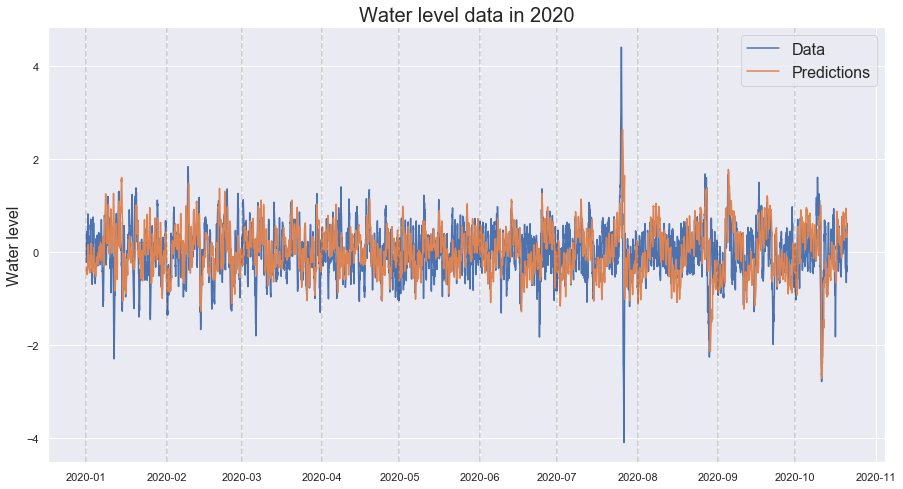

In [245]:
plot_prediction(wl_test, rolling_pred_df)

We could see that the prediction is much better, especially in the first half period. Unfortunately, the pattern starts to diverge in the second half period.

# SARIMA with exogenous  variables

## Correlation

In [233]:
def plot_corr(corr):
    sns.set(rc={'figure.figsize':(6,5)})
    ax = sns.heatmap(corr, cmap='Greens', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

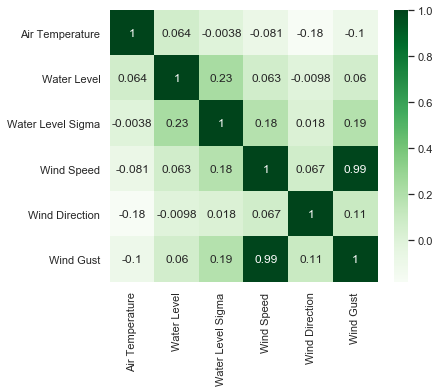

In [109]:
plot_corr(train.corr(method='spearman'))

Looking at the correlation between those attributes, Wind Speed and Wind Gust are highly correlated, so I decided to include only Wind Speed in the 2nd model.

## Training SARIMAX

In [106]:
model = SARIMAX(train['Water Level'], exog=train[['Wind Speed', 'Wind Direction']], \
                order=(0,1,0), seasonal_order=(1,0,1,24))
model_fit = model.fit()
model_fit.summary()

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Water Level   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6753.675
Date:                              Mon, 02 Nov 2020   AIC                         -13497.351
Time:                                      15:35:00   BIC                         -13458.509
Sample:                                  01-02-2018   HQIC                        -13484.559
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Wind Speed         0.0016      0.000      3.966      0.000       0.001       0.002
Wind Direction  -4.61e-05    1.8e-05     -2.559      0.010   -8.14e-05   -1.08e-05
ar.S.L24           0.6747      0.006    109.086      0.000       0.663       0.687
ma.S.L24          -0.9929      0.005   -207.046      0.000      -1.002      -0.984
sigma2             0.0268      0.000    115.374      0.000       0.026       0.027
===================================================================================
Ljung-Box (L1) (Q):                 832.52   Jarque-Bera (JB):              1683.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Rolling Forecast

In [234]:
from IPython.display import display, clear_output

def train_sarimax_model(train, test, exogs):
    history_wl = [x for x in train['Water Level'].values]
    history_exog = [x for x in train[exogs].values]
    future_wl = test['Water Level'].copy()
    future_exog = test[exogs].copy()

    sarimax_pred = list()

    # time tracking
    start = time()

    steps = 24    # a day
    total_steps = int(len(wl_test) / steps)

    for t in range(total_steps):
        print('Date: {}/{}'.format(t, total_steps))
        print_elapsed_time(start)

        # train
        model = SARIMAX(history_wl, exog=history_exog, \
                        order=(0,1,0), seasonal_order=(1,0,1,24))
        model_fit = model.fit()

        # predict
        output = model_fit.forecast(steps, exog=future_exog[t:t+steps])
        yhat = output
        sarimax_pred.extend(yhat)

        # add current water level to training data
        obs = future_wl[t*steps:(t+1)*steps].values
        history_wl.extend(obs)
        # also the exog data
        history_exog.extend(future_exog[t*steps:(t+1)*steps].values)

        clear_output(wait=True)
        # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

    clear_output(wait=True)
    print_elapsed_time(start)
    
    return sarimax_pred

In [235]:
sarimax_pred = train_sarimax_model(train, test, exogs=['Wind Speed', 'Wind Direction'])

Elapsed time: 7:00:19


In [297]:
sarimax_pred_df = pd.DataFrame(sarimax_pred, columns=['Water Level'], index=wl_test[:len(sarimax_pred)].index)
# sarimax_pred_df

In [328]:
eval_sarimax = evaluate(wl_test[:len(sarimax_pred_df)], sarimax_pred_df, 'sarimax w/ wind')
eval_sarimax

,Model,RMSE,R2,MSE,ME,MAE,MedAE
sarimax w/ wind,sarimax w/ wind,0.638,-0.588,0.407,0.009,0.475,0.389


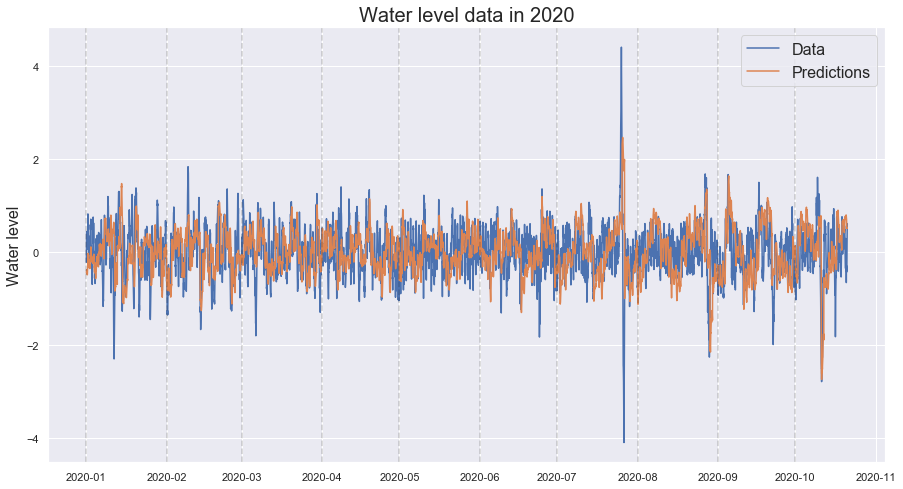

In [246]:
plot_prediction(wl_test, sarimax_pred_df)

The result doesn't have any significant difference from the previous model, while those errors metrics are slightly higher.

# Final evaluation

In [329]:
eval_final = pd.concat([eval_sarima_24, eval_sarimax])
eval_final.to_csv('metrics.csv')
eval_final

,Model,RMSE,R2,MSE,ME,MAE,MedAE
sarima_24,sarima_24,0.623,-0.460,0.388,0.033,0.463,0.377
sarimax w/ wind,sarimax w/ wind,0.638,-0.588,0.407,0.009,0.475,0.389
